In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime,timedelta
import scipy.integrate as spi
import pylab as pl
#from pylab import *

from lmfit import minimize, Parameters, Parameter, report_fit
from scipy.signal import savgol_filter
import operator
from pyDOE import *
from mpl_toolkits.mplot3d import Axes3D
#from pylab import *

In [2]:
data2=pd.read_csv("data2.csv")
alive1911=pd.read_csv("alivein1911.csv")
cause=pd.Series(data2['Cause of Death'])
measles=data2[cause.str.contains('measles')==True]
cause=pd.Series(alive1911['Cause of Death'])
measles1911=alive1911[cause.str.contains('measles')==True]

In [3]:
measles_only=np.array([])
for i in range(len(measles1911)):
    
    if measles1911['Cause of Death'].values[i]=='measles':
        measles_only=np.hstack((measles_only,measles1911['Deathdate'].values[i]))

In [4]:
measles_diarrhoea=np.array([])
for i in range(len(measles1911)):
    
    if measles1911['Cause of Death'].values[i]=='measles, diarrhoea':
        measles_diarrhoea=np.hstack((measles_diarrhoea,measles1911['Deathdate'].values[i]))
    
    elif measles1911['Cause of Death'].values[i]=='measles, diahrroea':
        measles_diarrhoea=np.hstack((measles_diarrhoea,measles1911['Deathdate'].values[i]))  
    elif measles1911['Cause of Death'].values[i]=='measles, ileo-colitis':
        measles_diarrhoea=np.hstack((measles_diarrhoea,measles1911['Deathdate'].values[i])) 
    elif measles1911['Cause of Death'].values[i]=='measles, diarrhoea,\x0bheart failure':
        measles_diarrhoea=np.hstack((measles_diarrhoea,measles1911['Deathdate'].values[i])) 
        
    elif measles1911['Cause of Death'].values[i]=='measles, diarrhoea,\x0bchildbirth':
        measles_diarrhoea=np.hstack((measles_diarrhoea,measles1911['Deathdate'].values[i])) 
        
    elif measles1911['Cause of Death'].values[i]== 'measles, diarrhoea,\x0bmiscarriage':
        measles_diarrhoea=np.hstack((measles_diarrhoea,measles1911['Deathdate'].values[i])) 
    
    elif measles1911['Cause of Death'].values[i]== 'measles, gastritis':
        measles_diarrhoea=np.hstack((measles_diarrhoea,measles1911['Deathdate'].values[i])) 
        

In [5]:
measles_only=sorted(measles_only,key=lambda x: datetime.strptime(x, '%d/%m/%Y'))
measles_diar=sorted(measles_diarrhoea,key=lambda x: datetime.strptime(x, '%d/%m/%Y'))
deathmeasles=pd.unique(measles_diar)
daterange=pd.date_range(deathmeasles[0],deathmeasles[-1],freq='D')

In [6]:
values3=np.zeros(len(daterange))
deathtime3=np.zeros(len(daterange))
for i in range(len(daterange)):
    for j in range(len(measles_only)):
        if daterange[i]==datetime.strptime(measles_only[j],'%d/%m/%Y'):
            #print(i)
            #print(j)
            values3[i]=values3[i]+1

In [7]:
values2=np.zeros(len(daterange))
deathtime2=np.zeros(len(daterange))
for i in range(len(daterange)):
    for j in range(len(measles_diarrhoea)):
        if daterange[i]==datetime.strptime(measles_diarrhoea[j],'%d/%m/%Y'):
            #print(i)
            #print(j)
            values2[i]=values2[i]+1

In [8]:
measles_timeseries=np.hstack((np.zeros(30),values3,np.zeros(10)))
coinf_timeseries=np.hstack((np.zeros(30),values2,np.zeros(10)))
measles_timeseries2=np.hstack((np.zeros(10),values3,np.zeros(30)))
coinf_timeseries2=np.hstack((np.zeros(10),values2,np.zeros(30)))
measles_timeseries3=np.hstack((np.zeros(1),values3,np.zeros(39)))
coinf_timeseries3=np.hstack((np.zeros(1),values2,np.zeros(39)))

In [9]:
np.savetxt("coinf_timeseries.csv",coinf_timeseries,delimiter=",")
np.savetxt("measles_timeseries.csv",measles_timeseries,delimiter=",")

In [9]:
def coinf_exp_model(INP,t,ps):  
    try:
        beta0=ps['beta0'].value
        beta1=ps['beta1'].value
#     beta=np.hstack((ps['beta0'].value,ps['beta1'].value))
        gamma0=ps['gamma0'].value
        gamma1=ps['gamma1'].value
        c1=ps['c1'].value
        c2=ps['c2'].value
        c3=ps['c3'].value
        sigma=ps['sigma'].value
        omega0=ps['omega0'].value
        omega1=ps['omega1'].value
#         alpha0=ps['alpha0'].value
#         alpha1=ps['alpha1'].value
    except:
        beta0,beta1,gamma0,gamma1,c=ps
    N=2618
    #omega0=1
    omega=np.hstack((omega0,omega0))
    #mu=np.array([c1,0,0])
    mu=np.array([c1*omega[0],c1*omega[1]+c2*omega[1],c2*gamma1])
    #mu=np.array([c1*omega[0],c2*omega[1],c2*gamma1])
    beta=np.hstack((beta0/N,beta1/N))
    #alpha=np.array([alpha0,alpha1])
    #alpha=np.array([0,0])
    Y=np.zeros((12))
    V = INP    
    #SS
    
    Y[0]=-beta[0]*V[0]*(V[1]+V[3]+V[5]+V[7]+V[9])-beta[1]*V[0]*(V[4]+V[5])+gamma0*V[1]
    
 
    #IS 0 pathogen
    Y[1]=beta[0]*V[0]*(V[1]+V[3]+V[5]+V[7]+V[9])-beta[1]*V[1]*(V[4]+V[5])-gamma0*V[1]
    
    #SE 1 measles
    
    Y[2]=beta[1]*V[0]*(V[4]+V[5])-sigma*V[2]-beta[0]*V[2]*(V[1]+V[3]+V[5]+V[7]+V[9])+gamma0*V[3]
    
    #IE
    
    Y[3]= beta[0]*V[2]*(V[1]+V[3]+V[5]+V[7]+V[9])-gamma0*V[3]-sigma*V[3]+beta[1]*V[1]*(V[4]+V[5])
    
    #SI 1 measles
    Y[4]=sigma*V[2]-beta[0]*V[4]*(V[1]+V[3]+V[5]+V[7]+V[9])-omega[0]*V[4]+gamma0*V[5]-mu[0]*V[4]
    
    
    #II 0 and 1 measles and pathogen
    Y[5]=beta[0]*V[4]*(V[1]+V[3]+V[5]+V[7]+V[9])+sigma*V[3]-gamma0*V[5]-omega[1]*V[5]-mu[1]*V[5]
    
    

    #SX immunosuppressed
    #Y[6]=alpha[0]*omega[0]*V[4]-gamma1*V[6]+gamma0*V[7]-beta[0]*V[6]*(V[1]+V[3]+V[5]+V[7]+V[9])
    
    
    
    Y[6]=omega[0]*V[4]-gamma1*V[6]+gamma0*V[7]-beta[0]*V[6]*(V[1]+V[3]+V[5]+V[7]+V[9])
    

    
    #IX
    #Y[7]=alpha[1]*omega[1]*V[5]+beta[0]*V[6]*(V[1]+V[3]+V[5]+V[7]+V[9])-gamma1*V[7]-mu[2]*V[7]-gamma0*V[7]
    
    Y[7]=omega[1]*V[5]+beta[0]*V[6]*(V[1]+V[3]+V[5]+V[7]+V[9])-gamma1*V[7]-mu[2]*V[7]-gamma0*V[7]
    

    #SR
    #Y[8]=(1-alpha[0])*omega[0]*V[4]+gamma0*V[9]-beta[0]*V[8]*(V[1]+V[3]+V[5]+V[7]+V[9])
    
    Y[8]=gamma1*V[6]+gamma0*V[9]-beta[0]*V[8]*(V[1]+V[3]+V[5]+V[7]+V[9])
    
   
    
    #IR
    #Y[9]=(1-alpha[1])*omega[1]*V[5]+beta[0]*V[8]*(V[1]+V[3]+V[5]+V[7]+V[9])+gamma1*V[7]-gamma0*V[9]
    
    
    Y[9]=beta[0]*V[8]*(V[1]+V[3]+V[5]+V[7]+V[9])+gamma1*V[7]-gamma0*V[9]
    
    Y[10]=mu[0]*V[4]
    Y[11]=mu[1]*V[5]+mu[2]*V[7]

    
    return Y   # For odeint


In [10]:
N=2618
#sigma=1/14
IS0=670
SE0=0
IE0=0
SI0=2
II0=0
SX0=0
IX0=0
SR0=0
IR0=0
SS0=N-IS0-SE0-SI0
INPUT=(SS0,IS0,SE0,IE0,SI0,II0,SX0,IX0,SR0,IR0,0,0)
ts_len=len(measles_timeseries)
def g(t, INP, ps):
    RES = spi.odeint(coinf_exp_model,INP,t,args=(ps,))
    res_measles=RES[1:ts_len+1,10]-RES[0:ts_len,10]
    res_coinf=RES[1:ts_len+1,11]-RES[0:ts_len,11]
    
    x=np.array((res_measles,res_coinf))
    #x = odeint(f, x0, t, args=(ps,))
    return x

def residual(ps,INP, ts, data):
    #x0 = ps['x0'].value
    #model = g(ts, x0, ps)
    
    RES = spi.odeint(coinf_exp_model,INP,ts,args=(ps,))
    res_measles=RES[1:ts_len+1,10]-RES[0:ts_len,10]
    res_coinf=RES[1:ts_len+1,11]-RES[0:ts_len,11]
#     index1, value = max(enumerate(res_measles), key=operator.itemgetter(1))
#     index2, value = max(enumerate(res_coinf), key=operator.itemgetter(1))
     
    model=np.array((res_measles,res_coinf))
 # ,index1,index2))
    return (model - data).ravel()

# a = 2.0
# b = 0.5
# true_params = [a, b]
# x0 = 10.0

TS=1.0
ND=float(ts_len+1)
t_start = 0.0; t_end = ND; t_inc = TS
t_range = np.arange(t_start, t_end+t_inc, t_inc)

measles_ts_smooth = savgol_filter(measles_timeseries, 41, 3)
coinf_ts_smooth = savgol_filter(coinf_timeseries, 41, 3)
#time_series=np.array((measles_ts_smooth,coinf_ts_smooth))
time_series=np.array((measles_timeseries,coinf_timeseries))
#time_series=np.array((measles_timeseries,coinf_timeseries,71,88))
# t = np.linspace(0, 10, 10)
# data = g(t, x0, true_params)
# data += np.random.normal(size=data.shape)

# set parameters incluing bounds
params = Parameters()
params.add('beta0',value=1.2,min=0.001,max=3)
params.add('beta1',value=0.4,min=0.1,max=5)
params.add('gamma0',value=0.1,min=0.005,max=0.9)
params.add('gamma1',value=0.1,min=0.01,max=2)
params.add('c1',value=0.1,min=0.001,max=0.5)
params.add('c2',value=0.1,min=0.001,max=0.5)
params.add('c3',value=0.1,min=0.001,max=0.5)
params.add('sigma',value=0.1,min=1/21,max=1/4)
params.add('omega0',value=0.1,min=1/21,max=1/4)
params.add('omega1',value=0.1,min=1/20,max=1/2)
#params.add('IS',value=600,min=1,max=2618)
#params.add('alpha0',value=0.9,min=0,max=1)
#params.add('alpha1',value=0.9,min=0,max=1)

# params.add('x0', value=float(data[0]), min=0, max=100)
# params.add('a', value= 1.0, min=0, max=10)
# params.add('b', value= 1.0, min=0, max=10)

# fit model and find predicted values
#result = minimize(residual, params, args=(INPUT,t_range, time_series), method='leastsq')
result = minimize(residual, params, args=(INPUT,t_range, time_series), method='lbfgsb' )
final = time_series + result.residual.reshape(time_series.shape)


/home/susanna/anaconda3/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


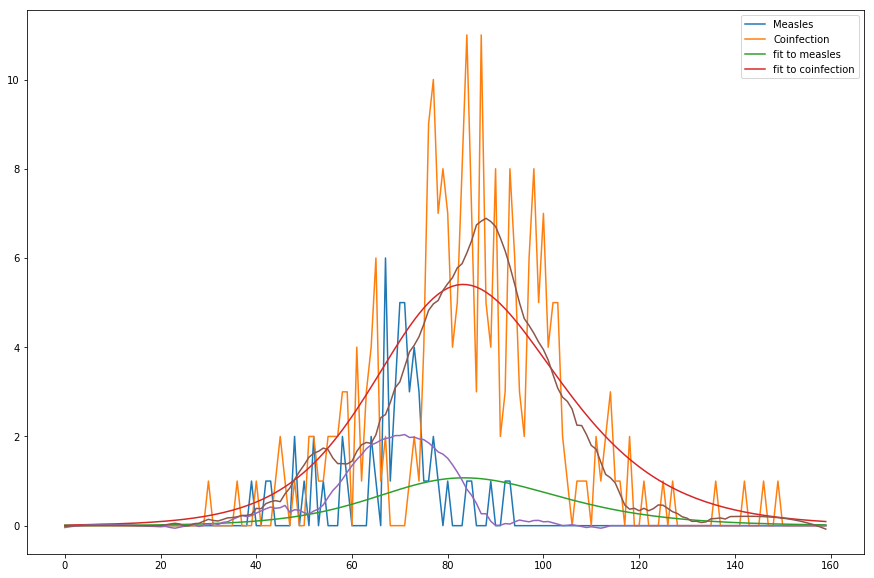

In [11]:
plt.figure(figsize=(15,10))
#RES = spi.odeint(coinf_exp_model,INPUT,t_range,result.params())
#plt.plot(RES[:,5])
plt.plot(time_series[0],label="Measles")
plt.plot(time_series[1],label="Coinfection")
plt.plot(final[0],label="fit to measles")
plt.plot(final[1],label="fit to coinfection")
measles_ts_smooth = savgol_filter(measles_timeseries, 41, 3)
coinf_ts_smooth = savgol_filter(coinf_timeseries, 41, 3)
plt.plot(measles_ts_smooth)
plt.plot(coinf_ts_smooth)
# beta0,beta1,gamma0,gamma1,c=1.2,1.5,0.1,0.1,0.3
# true_params = np.array((beta0,beta1,gamma0,gamma1,c))
# data = g(t_range, INPUT, true_params)
#data += np.random.normal(size=data.shape)
# plt.plot(data[0],label="Measles")
# plt.plot(data[1],label="coinf")
plt.legend()
plt.show()

In [15]:
(result.residual)

array([  1.26046957e-02,   9.10177737e-03,   7.07189840e-03,
         6.01391799e-03,   5.56453595e-03,   5.48798674e-03,
         5.64477796e-03,   5.95663484e-03,   6.38085500e-03,
         6.89484293e-03,   7.48748000e-03,   8.15439790e-03,
         8.89537071e-03,   9.71285470e-03,   1.06111621e-02,
         1.15959938e-02,   1.26741811e-02,   1.38535515e-02,
         1.51428704e-02,   1.65518294e-02,   1.80910678e-02,
         1.97722103e-02,   2.16079271e-02,   2.36119811e-02,
         2.57993457e-02,   2.81862209e-02,   3.07901664e-02,
         3.36301722e-02,   3.67267501e-02,   4.01020275e-02,
         4.37798398e-02,   4.77858279e-02,   5.21474959e-02,
         5.68943739e-02,   6.20579818e-02,   6.76719749e-02,
         7.37721641e-02,   8.03965410e-02,   8.75852855e-02,
        -9.04619260e-01,   1.03827325e-01,   1.12971451e-01,
        -8.77138671e-01,  -8.66453258e-01,   1.45078741e-01,
         1.57509245e-01,   1.70890556e-01,   1.85274751e-01,
        -1.79928704e+00,

In [12]:
report_fit(result)

[[Fit Statistics]]
    # fitting method   = L-BFGS-B
    # function evals   = 1485
    # data points      = 320
    # variables        = 10
    chi-square         = 523.914943
    reduced chi-square = 1.69004820
    Akaike info crit   = 177.762673
    Bayesian info crit = 215.445883
[[Variables]]
    beta0:   0.98784668 (init = 1.2)
    beta1:   0.33159226 (init = 0.4)
    gamma0:  0.34799231 (init = 0.1)
    gamma1:  0.24078635 (init = 0.1)
    c1:      0.06799435 (init = 0.1)
    c2:      0.07178437 (init = 0.1)
    c3:      0.10000000 (init = 0.1)
    sigma:   0.16058352 (init = 0.1)
    omega0:  0.11031387 (init = 0.1)
    omega1:  0.10000000 (init = 0.1)


In [16]:
result.params.pretty_print()

Name       Value      Min      Max   Stderr     Vary     Expr Brute_Step
beta0     0.9878    0.001        3     None     True     None     None
beta1     0.3316      0.1        5     None     True     None     None
c1       0.06799    0.001      0.5     None     True     None     None
c2       0.07178    0.001      0.5     None     True     None     None
c3           0.1    0.001      0.5     None     True     None     None
gamma0     0.348    0.005      0.9     None     True     None     None
gamma1    0.2408     0.01        2     None     True     None     None
omega0    0.1103  0.04762     0.25     None     True     None     None
omega1       0.1     0.05      0.5     None     True     None     None
sigma     0.1606  0.04762     0.25     None     True     None     None


In [151]:
N=2618

ts_len=len(measles_timeseries)
def g(t, INP, ps):
    RES = spi.odeint(coinf_exp_model,INP,t,args=(ps,))
    res_measles=RES[1:ts_len+1,10]-RES[0:ts_len,10]
    res_coinf=RES[1:ts_len+1,11]-RES[0:ts_len,11]
    
    x=np.array((res_measles,res_coinf))
    #x = odeint(f, x0, t, args=(ps,))
    return x

def residual(ps,ts, data):

    #IS=ps['IS'].value
    N=2618
    beta=ps['beta0'].value
    gamma=ps['gamma0'].value
    IS=(1-(gamma/beta))*N
    INP=(N-IS-2,IS,2,0,0,0,0,0,0,0,0,0)
    RES = spi.odeint(coinf_exp_model,INP,ts,args=(ps,))
    res_measles=RES[1:ts_len+1,10]-RES[0:ts_len,10]
    res_coinf=RES[1:ts_len+1,11]-RES[0:ts_len,11]
#     index1, value = max(enumerate(res_measles), key=operator.itemgetter(1))
#     index2, value = max(enumerate(res_coinf), key=operator.itemgetter(1))
     
    model=np.array((res_measles,res_coinf))
 # ,index1,index2))
    return (model - data).ravel()

# a = 2.0
# b = 0.5
# true_params = [a, b]
# x0 = 10.0

TS=1.0
ND=float(ts_len+1)
t_start = 0.0; t_end = ND; t_inc = TS
t_range = np.arange(t_start, t_end+t_inc, t_inc)

measles_ts_smooth = savgol_filter(measles_timeseries, 41, 3)
coinf_ts_smooth = savgol_filter(coinf_timeseries, 41, 3)
#time_series=np.array((measles_ts_smooth,coinf_ts_smooth))
time_series=np.array((measles_timeseries,coinf_timeseries))
#time_series=np.array((measles_timeseries,coinf_timeseries,71,88))
# t = np.linspace(0, 10, 10)
# data = g(t, x0, true_params)
# data += np.random.normal(size=data.shape)

# set parameters incluing bounds
params = Parameters()
params.add('beta0',value=1.2,min=0.001,max=3)
params.add('beta1',value=0.4,min=0.1,max=5)
params.add('gamma0',value=0.1,min=0.005,max=0.9)
params.add('gamma1',value=0.1,min=0.01,max=1)
params.add('c1',value=0.1,min=0.001,max=0.5)
params.add('c2',value=0.1,min=0.001,max=0.5)
params.add('c3',value=0.1,min=0.001,max=0.5)
params.add('sigma',value=0.1,min=1/21,max=1/4)
params.add('omega0',value=0.1,min=1/21,max=1/4)
params.add('omega1',value=0.1,min=1/20,max=1/2)
#params.add('IS',value=600,min=1,max=2618)
#params.add('alpha0',value=0.9,min=0,max=1)
#params.add('alpha1',value=0.9,min=0,max=1)

# params.add('x0', value=float(data[0]), min=0, max=100)
# params.add('a', value= 1.0, min=0, max=10)
# params.add('b', value= 1.0, min=0, max=10)

# fit model and find predicted values
result = minimize(residual, params, args=(t_range, time_series), method='leastsq')
final = time_series + result.residual.reshape(time_series.shape)


In [139]:
(1-1/(0.3892/0.123))*N

1790.6258992805756

In [145]:
(1-1/(0.9805/0.3089))*N

1793.2165221825599

In [152]:
report_fit(result)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 294
    # data points      = 320
    # variables        = 10
    chi-square         = 506.820482
    reduced chi-square = 1.63490478
    Akaike info crit   = 167.147477
    Bayesian info crit = 204.830687
[[Variables]]
    beta0:   2.13197980 (init = 1.2)
    beta1:   0.40180362 (init = 0.4)
    gamma0:  0.10324774 (init = 0.1)
    gamma1:  0.21397358 (init = 0.1)
    c1:      0.49999611 (init = 0.1)
    c2:      0.06595631 (init = 0.1)
    c3:      0.10000000 (init = 0.1)
    sigma:   0.14313877 (init = 0.1)
    omega0:  0.12955448 (init = 0.1)
    omega1:  0.10000000 (init = 0.1)


In [153]:
result.params.pretty_print()

Name       Value      Min      Max   Stderr     Vary     Expr Brute_Step
beta0      2.132    0.001        3     None     True     None     None
beta1     0.4018      0.1        5     None     True     None     None
c1           0.5    0.001      0.5     None     True     None     None
c2       0.06596    0.001      0.5     None     True     None     None
c3           0.1    0.001      0.5     None     True     None     None
gamma0    0.1032    0.005      0.9     None     True     None     None
gamma1     0.214     0.01        1     None     True     None     None
omega0    0.1296  0.04762     0.25     None     True     None     None
omega1       0.1     0.05      0.5     None     True     None     None
sigma     0.1431  0.04762     0.25     None     True     None     None


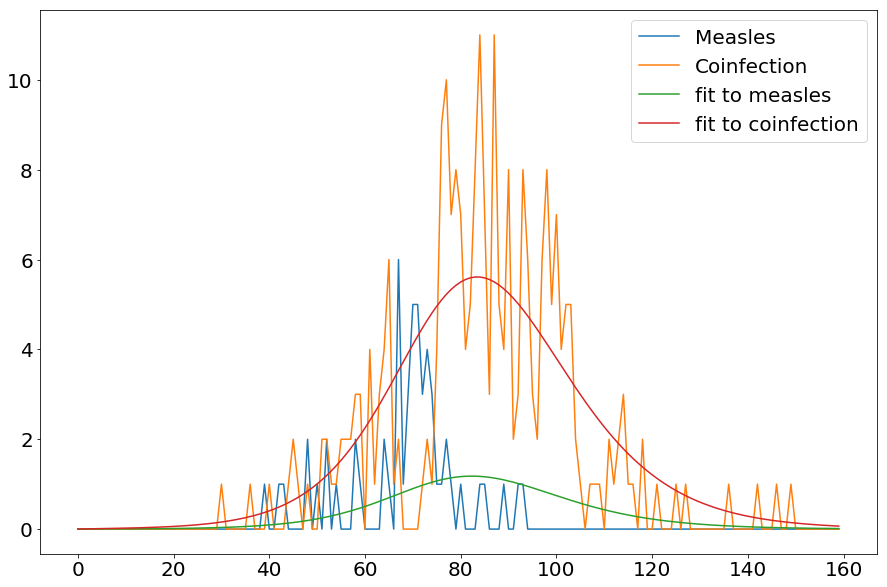

In [154]:
plt.figure(figsize=(15,10))
#RES = spi.odeint(coinf_exp_model,INPUT,t_range,result.params())
#plt.plot(RES[:,5])
plt.plot(time_series[0],label="Measles")
plt.plot(time_series[1],label="Coinfection")
plt.plot(final[0],label="fit to measles")
plt.plot(final[1],label="fit to coinfection")
measles_ts_smooth = savgol_filter(measles_timeseries, 41, 3)
coinf_ts_smooth = savgol_filter(coinf_timeseries, 41, 3)
#plt.plot(measles_ts_smooth)
#plt.plot(coinf_ts_smooth)
# beta0,beta1,gamma0,gamma1,c=1.2,1.5,0.1,0.1,0.3
# true_params = np.array((beta0,beta1,gamma0,gamma1,c))
# data = g(t_range, INPUT, true_params)
#data += np.random.normal(size=data.shape)
# plt.plot(data[0],label="Measles")
# plt.plot(data[1],label="coinf")
plt.legend()
plt.show()

In [65]:
def coinf_exp_model1(INP,t):  

    N=2618

    Y=np.zeros((12))
    V = INP    
    #SS
    
    Y[0]=-beta[0]*V[0]*(V[1]+V[3]+V[5]+V[7]+V[9])-beta[1]*V[0]*(V[4]+V[5])+gamma0*V[1]
    
 
    #IS 0 pathogen
    Y[1]=beta[0]*V[0]*(V[1]+V[3]+V[5]+V[7]+V[9])-beta[1]*V[1]*(V[4]+V[5])-gamma0*V[1]
    
    #SE 1 measles
    
    Y[2]=beta[1]*V[0]*(V[4]+V[5])-sigma*V[2]-beta[0]*V[2]*(V[1]+V[3]+V[5]+V[7]+V[9])+gamma0*V[3]
    
    #IE
    
    Y[3]= beta[0]*V[2]*(V[1]+V[3]+V[5]+V[7]+V[9])-gamma0*V[3]-sigma*V[3]+beta[1]*V[1]*(V[4]+V[5])
    
    #SI 1 measles
    Y[4]=sigma*V[2]-beta[0]*V[4]*(V[1]+V[3]+V[5]+V[7]+V[9])-omega[0]*V[4]+gamma0*V[5]-mu[0]*V[4]
    
    
    #II 0 and 1 measles and pathogen
    Y[5]=beta[0]*V[4]*(V[1]+V[3]+V[5]+V[7]+V[9])+sigma*V[3]-gamma0*V[5]-omega[1]*V[5]-mu[1]*V[5]
    
    #SX
    
    Y[6]=omega[0]*V[4]-gamma1*V[6]+gamma0*V[7]-beta[0]*V[6]*(V[1]+V[3]+V[5]+V[7]+V[9])
    
    #IX
    
    Y[7]=omega[1]*V[5]+beta[0]*V[6]*(V[1]+V[3]+V[5]+V[7]+V[9])-gamma1*V[7]-mu[2]*V[7]-gamma0*V[7]
    

    #SR

    
    Y[8]=gamma1*V[6]+gamma0*V[9]-beta[0]*V[8]*(V[1]+V[3]+V[5]+V[7]+V[9])
    
   
    
    #IR
    
    
    Y[9]=beta[0]*V[8]*(V[1]+V[3]+V[5]+V[7]+V[9])+gamma1*V[7]-gamma0*V[9]
    
    Y[10]=mu[0]*V[4]
    Y[11]=mu[1]*V[5]+mu[2]*V[7]

    
    return Y   # For odeint


In [11]:
def sq_calc(model,data):

    return np.square((model-data).ravel())

In [61]:
N=2618
beta0=0.9/N
beta1= 0.33/N
gamma0= 0.34
gamma1=0.24
c1=0.1
c2=0.1
c3=0.2 
sigma=0.16
omega0=  0.1
omega1=  0.10000000 
IS0=670
SE0=2
IE0=0
SI0=0
II0=0
SX0=0
IX0=0
SR0=0
IR0=0
SS0=N-IS0-SE0
INPUT=(SS0,IS0,SE0,IE0,SI0,II0,SX0,IX0,SR0,IR0,0,0)


# beta0:   0.98784668 (init = 1.2)
#     beta1:   0.33159226 (init = 0.4)
#     gamma0:  0.34799231 (init = 0.1)
#     gamma1:  0.24078635 (init = 0.1)
#     c1:      0.06799435 (init = 0.1)
#     c2:      0.07178437 (init = 0.1)
#     c3:      0.10000000 (init = 0.1)
#     sigma:   0.16058352 (init = 0.1)
#     omega0:  0.11031387 (init = 0.1)
#     omega1:  0.10000000 (init = 0.1)


In [62]:
RES = spi.odeint(coinf_exp_model1,INPUT,t_range)
res_measles=RES[1:ts_len+1,10]-RES[0:ts_len,10]
res_coinf=RES[1:ts_len+1,11]-RES[0:ts_len,11]

x=np.array((res_measles,res_coinf))

/home/susanna/anaconda3/lib/python3.6/site-packages/scipy/integrate/odepack.py:218: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


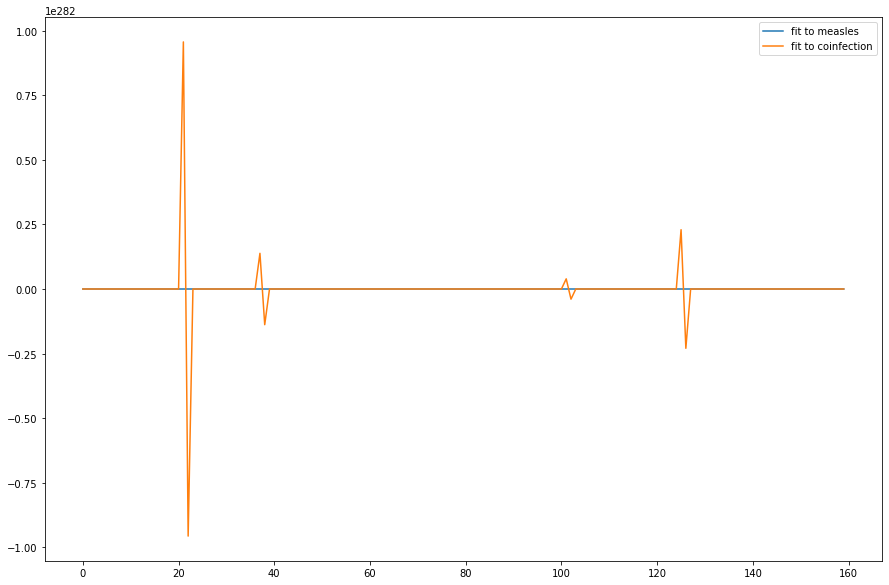

In [63]:
plt.figure(figsize=(15,10))

#plt.plot(time_series[0],label="Measles")
#plt.plot(time_series[1],label="Coinfection")
plt.plot(x[0],label="fit to measles")
plt.plot(x[1],label="fit to coinfection")

plt.legend()
plt.show()

In [21]:
chi_sq_f=sum(sq_calc(x,time_series))

In [26]:
m_smooth = savgol_filter(measles_timeseries, 41, 3)
c_smooth = savgol_filter(coinf_timeseries, 41, 3)
peak_m=np.argmax(m_smooth)
peak_c=np.argmax(c_smooth)
peak_data=np.array((peak_m,peak_c,max(m_smooth),max(c_smooth)))

samps=10000
lh=lhs(8,samples=samps)
N=2618
IS0=670
SE0=0
IE0=0
SI0=2
II0=0
SX0=0
IX0=0
SR0=0
IR0=0
SS0=N-IS0-SE0
INPUT=(SS0,IS0,SE0,IE0,SI0,II0,SX0,IX0,SR0,IR0,0,0)
ts_len=len(measles_timeseries)
TS=1.0
ND=float(ts_len+1)
t_start = 0.0; t_end = ND; t_inc = TS
t_range = np.arange(t_start, t_end+t_inc, t_inc)
dist_peak=np.zeros(samps)
time_series=np.array((measles_timeseries,coinf_timeseries))

for i in range(samps):
    beta=np.array([lh[i,0],lh[i,1]])
    gamma0=lh[i,2]
    gamma1=lh[i,3]
    sigma=lh[i,4]
    omega=np.array([lh[i,5],lh[i,5]])
    c1=lh[i,6]
    c2=lh[i,7]
    mu=np.array([c1*omega[0],c2*omega[1],c2*gamma1])
    
    RES = spi.odeint(coinf_exp_model1,INPUT,t_range)
    res_measles=RES[1:ts_len+1,10]-RES[0:ts_len,10]
    res_coinf=RES[1:ts_len+1,11]-RES[0:ts_len,11]
    peak_resm=np.argmax(res_measles)
    peak_resc=np.argmax(res_coinf)
    peak_res=((peak_resm,peak_resc,max(res_measles),max(res_coinf)))
    
    dist_peak[i]=sum(sq_calc(peak_res,peak_data))
    

/home/susanna/anaconda3/lib/python3.6/site-packages/scipy/integrate/odepack.py:218: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


In [27]:
np.argmin(dist_peak)

226

In [29]:
min(dist_peak)

685.89512023676139

In [22]:
peak_resm=np.argmax(res_measles)
peak_resc=np.argmax(res_coinf)


551.08815218466896

In [50]:
samps=10000
lh=lhs(8,samples=samps)
N=2618
IS0=670
SE0=0
IE0=0
SI0=2
II0=0
SX0=0
IX0=0
SR0=0
IR0=0
SS0=N-IS0-SE0
INPUT=(SS0,IS0,SE0,IE0,SI0,II0,SX0,IX0,SR0,IR0,0,0)
ts_len=len(measles_timeseries)
TS=1.0
ND=float(ts_len+1)
t_start = 0.0; t_end = ND; t_inc = TS
t_range = np.arange(t_start, t_end+t_inc, t_inc)
sq=np.zeros(samps)
time_series=np.array((measles_timeseries,coinf_timeseries))

for i in range(samps):
    beta=np.array([lh[i,0],lh[i,1]])
    gamma0=lh[i,2]
    gamma1=lh[i,3]
    sigma=lh[i,4]
    omega=np.array([lh[i,5],lh[i,5]])
    c1=lh[i,6]
    c2=lh[i,7]
    mu=np.array([c1*omega[0],c2*omega[1],c2*gamma1])
    
    RES = spi.odeint(coinf_exp_model1,INPUT,t_range)
    res_measles=RES[1:ts_len+1,10]-RES[0:ts_len,10]
    res_coinf=RES[1:ts_len+1,11]-RES[0:ts_len,11]
    
    x=np.array((res_measles,res_coinf))
    sq[i]=sum(sq_calc(x,time_series))
    

In [52]:
less_600=np.array([666,1883,2501,3668,3857,6348,8441,9244])
less_600=np.array([3956,4363,9581,9785])

In [30]:
#i=less_600[3]
i=226
beta=np.array([lh[i,0],lh[i,1]])
gamma0=lh[i,2]
gamma1=lh[i,3]
sigma=lh[i,4]
omega=np.array([lh[i,5],lh[i,5]])
c1=lh[i,6]
c2=lh[i,7]
mu=np.array([c1*omega[0],c2*omega[1],c2*gamma1])

RES = spi.odeint(coinf_exp_model1,INPUT,t_range)
res_measles=RES[1:ts_len+1,10]-RES[0:ts_len,10]
res_coinf=RES[1:ts_len+1,11]-RES[0:ts_len,11]

fit_samp=np.array((res_measles,res_coinf))

    

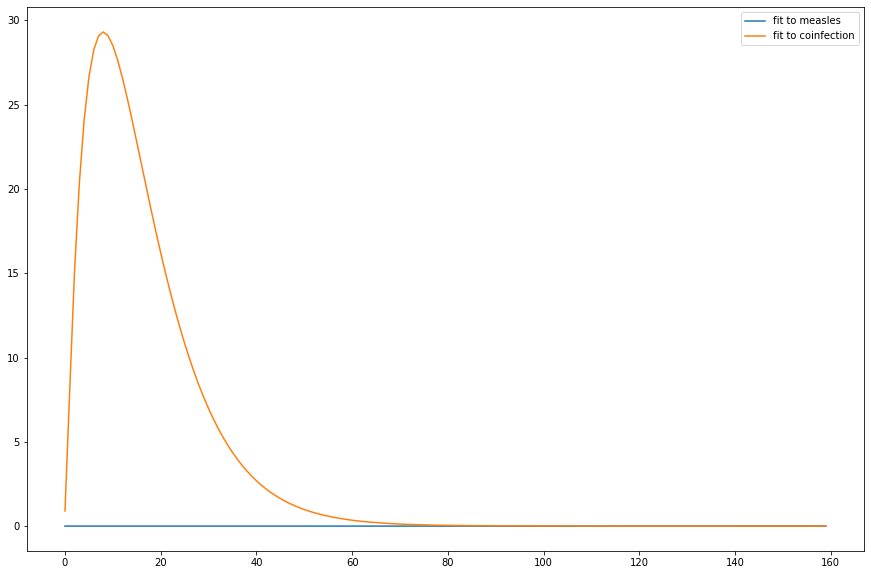

In [40]:
plt.figure(figsize=(15,10))

#plt.plot(time_series[0],label="Measles")
#plt.plot(time_series[1],label="Coinfection")
plt.plot(x[0],label="fit to measles")
plt.plot(x[1],label="fit to coinfection")

plt.legend()
plt.show()

In [11]:
from pylab import *

In [28]:
samps=20000
lh=lhs(9,samples=samps)
N=2618
IS0=670
SE0=0
IE0=0
SI0=2
II0=0
SX0=0
IX0=0
SR0=0
IR0=0
SS0=N-IS0-SE0
INPUT=(SS0,IS0,SE0,IE0,SI0,II0,SX0,IX0,SR0,IR0,0,0)
ts_len=len(measles_timeseries)
TS=1.0
ND=float(ts_len+1)
t_start = 0.0; t_end = ND; t_inc = TS
t_range = np.arange(t_start, t_end+t_inc, t_inc)
sep_peak=np.zeros(samps)
#time_series=np.array((measles_timeseries,coinf_timeseries))
sep_peak2=np.array([])
lh0=np.array([])
lh1=np.array([])
lh2=np.array([])
lh3=np.array([])
lh4=np.array([])
lh5=np.array([])
lh6=np.array([])
lh7=np.array([])
lh8=np.array([])
for i in range(samps):
    beta=np.array([lh[i,0]*5,lh[i,1]*3.17+(2/13)])
    gamma0=lh[i,2]
    gamma1=((1/6)-(1/13))*lh[i,3]+1/13
    sigma=lh[i,4]
    omega=np.array([lh[i,5],lh[i,5]])
    c1=lh[i,6]
    c2=lh[i,7]
    c3=lh[i,8]
    mu=np.array([c1*omega[0],c2*omega[1],c3*gamma1])
    
    RES = spi.odeint(coinf_exp_model1,INPUT,t_range)
    res_measles=RES[1:ts_len+1,10]-RES[0:ts_len,10]
    res_coinf=RES[1:ts_len+1,11]-RES[0:ts_len,11]
    peak_resm=np.argmax(res_measles)
    peak_resc=np.argmax(res_coinf)
    sep_peak[i]=np.absolute(peak_resm-peak_resc)
    if max(res_measles)>2 and max(res_coinf)>2 and sep_peak[i]>1:
        sep_peak2=np.append(sep_peak2,[sep_peak[i]])
        lh0=np.append(lh0,[lh[i,0]*5])
        lh1=np.append(lh1,[lh[i,1]*3.17+(2/13)])
        lh2=np.append(lh2,[lh[i,2]])
        lh3=np.append(lh3,[((1/6)-(1/13))*lh[i,3]+1/13])
        lh4=np.append(lh4,[lh[i,4]])
        lh5=np.append(lh5,[lh[i,5]])
        lh6=np.append(lh6,[lh[i,6]])
        lh7=np.append(lh7,[lh[i,7]])
        lh8=np.append(lh7,[lh[i,8]])

/home/susanna/anaconda3/lib/python3.6/site-packages/scipy/integrate/odepack.py:218: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


KeyboardInterrupt: 

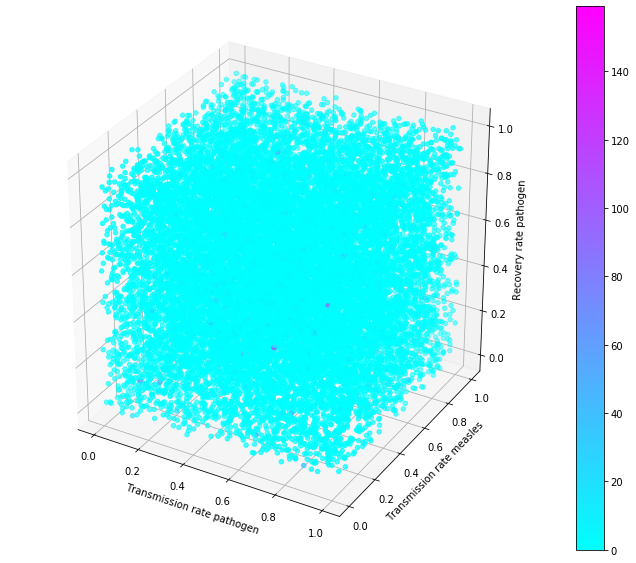

In [13]:
fig = plt.figure(figsize=(12,10))

ax = fig.add_subplot(111,projection='3d')
n = 1000

xs = lh[:,0]
ys = lh[:,1]
zs = lh[:,2]



colors = cm.cool(sep_peak/max(sep_peak))

colmap = cm.ScalarMappable(cmap=cm.cool)
colmap.set_array(sep_peak)

yg = ax.scatter(xs, ys, zs, c=colors, marker='o')
cb = fig.colorbar(colmap)

ax.set_xlabel('Transmission rate pathogen')
ax.set_ylabel('Transmission rate measles')
ax.set_zlabel('Recovery rate pathogen')

plt.show()


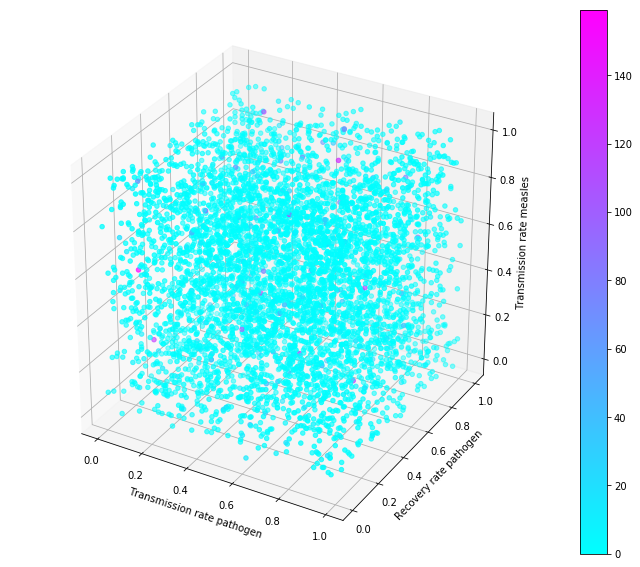

In [49]:
fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(111,projection='3d')
n = 1000

xs = lh[:,0]
ys = lh[:,2]
zs = lh[:,3]


colors = cm.cool(sep_peak/max(sep_peak))

colmap = cm.ScalarMappable(cmap=cm.cool)
colmap.set_array(sep_peak)

yg = ax.scatter(xs, ys, zs, c=colors, marker='o')
cb = fig.colorbar(colmap)

ax.set_xlabel('Transmission rate pathogen')
ax.set_zlabel('Transmission rate measles')
ax.set_ylabel('Recovery rate pathogen')
plt.show()

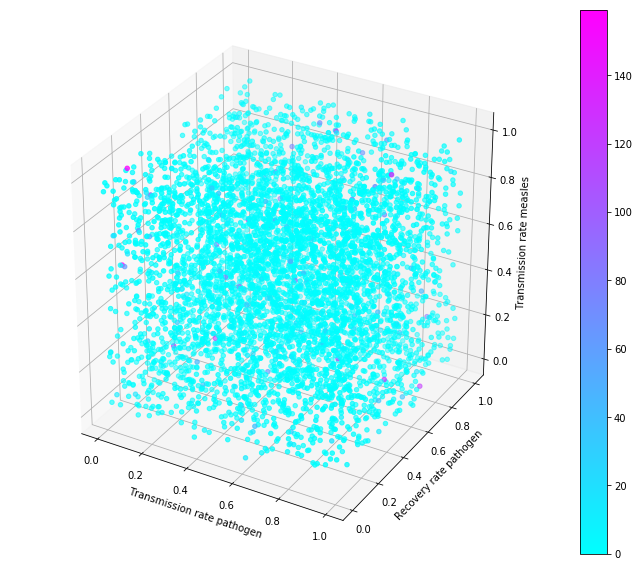

In [50]:
fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(111,projection='3d')
n = 1000

xs = lh[:,1]
ys = lh[:,2]
zs = lh[:,3]


colors = cm.cool(sep_peak[:]/max(sep_peak[:]))

colmap = cm.ScalarMappable(cmap=cm.cool)
colmap.set_array(sep_peak[:])

yg = ax.scatter(xs, ys, zs, c=colors, marker='o')
cb = fig.colorbar(colmap)

ax.set_xlabel('Transmission rate pathogen')
ax.set_zlabel('Transmission rate measles')
ax.set_ylabel('Recovery rate pathogen')
plt.show()

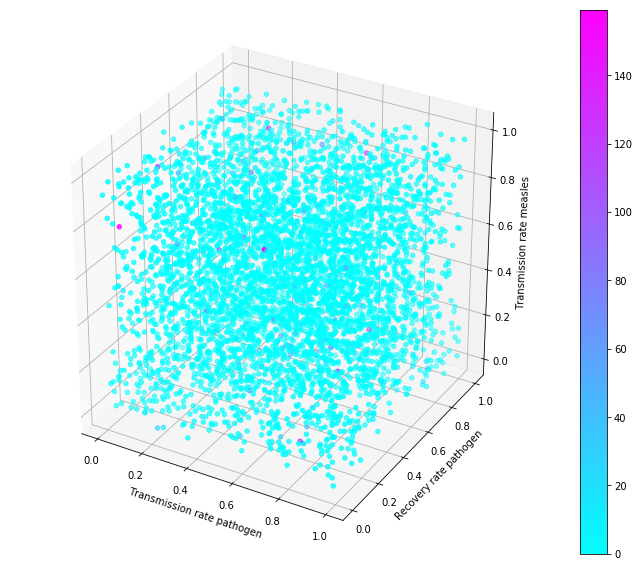

In [51]:
fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(111,projection='3d')
n = 1000

xs = lh[:,0]
ys = lh[:,1]
zs = lh[:,5]


colors = cm.cool(sep_peak/max(sep_peak))

colmap = cm.ScalarMappable(cmap=cm.cool)
colmap.set_array(sep_peak)

yg = ax.scatter(xs, ys, zs, c=colors, marker='o')
cb = fig.colorbar(colmap)

ax.set_xlabel('Transmission rate pathogen')
ax.set_zlabel('Transmission rate measles')
ax.set_ylabel('Recovery rate pathogen')
plt.show()

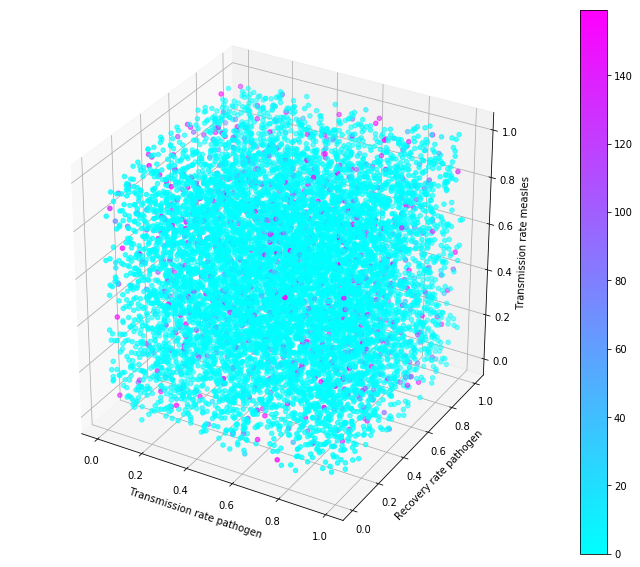

In [43]:
%matplot
fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(111,projection='3d')
n = 1000

xs = lh[:,2]
ys = lh[:,6]
zs = lh[:,7]


colors = cm.cool(sep_peak/max(sep_peak))

colmap = cm.ScalarMappable(cmap=cm.cool)
colmap.set_array(sep_peak)

yg = ax.scatter(xs, ys, zs, c=colors, marker='o')
cb = fig.colorbar(colmap)

ax.set_xlabel('Transmission rate pathogen')
ax.set_zlabel('Transmission rate measles')
ax.set_ylabel('Recovery rate pathogen')
plt.show()

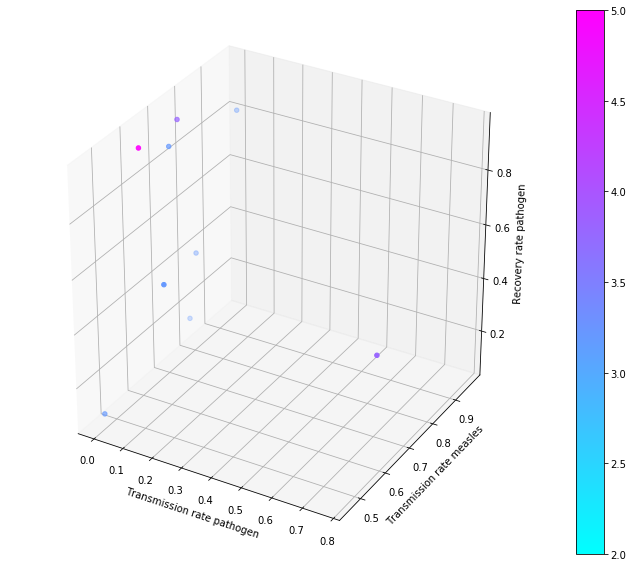

In [23]:
#%matplotlib qt5


fig = plt.figure(figsize=(12,10))

ax = fig.add_subplot(111,projection='3d')
n = 1000

xs = lh0
ys = lh1
zs = lh2



colors = cm.cool(sep_peak2/max(sep_peak2))

colmap = cm.ScalarMappable(cmap=cm.cool)
colmap.set_array(sep_peak2)

yg = ax.scatter(xs, ys, zs, c=colors, marker='o')
cb = fig.colorbar(colmap)

ax.set_xlabel('Transmission rate pathogen')
ax.set_ylabel('Transmission rate measles')
ax.set_zlabel('Recovery rate pathogen')

plt.show()


In [17]:
np.savetxt("coinf_timeseries.csv",coinf_timeseries,delimiter=",")

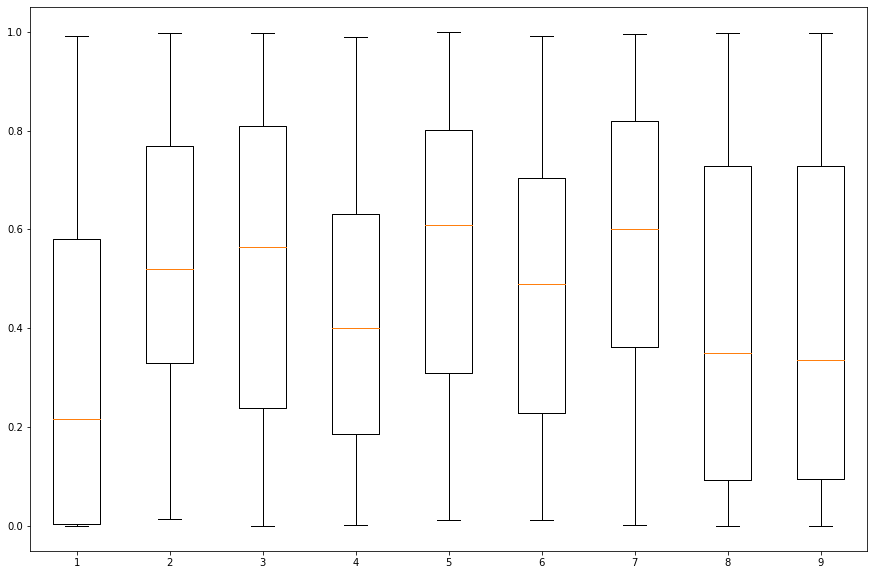

In [67]:

# data=np.concatenate((lh0, lh1, lh2,lh3))
# d2=np.concatenate((lh0, lh1, lh2,lh3))
# data.shape = (-1, 1)
# d2.shape = (-1, 1)
# Making a 2-D array only works if all the columns are the
# same length.  If they are not, then use a list instead.
# This is actually more efficient because boxplot converts
# a 2-D array into a list of vectors internally anyway.
#data = [data, d2, d2[::2, 0]]
data = [lh0, lh1, lh2,lh3,lh4,lh5,lh6,lh7,lh8]

fig, ax = plt.subplots(figsize=(15, 10))
ax.boxplot(data)
# plt.boxplot(lh0)
# plt.boxplot(lh1)
# plt.boxplot(lh2)
# plt.boxplot(lh3)
# plt.boxplot(lh4)
# plt.boxplot(lh5)
# plt.boxplot(lh6)
# plt.boxplot(lh7)
plt.show()

In [66]:
samps=50000
lh=lhs(9,samples=samps)
N=2618
IS0=670
SE0=0
IE0=0
SI0=2
II0=0
SX0=0
IX0=0
SR0=0
IR0=0
SS0=N-IS0-SE0
INPUT=(SS0,IS0,SE0,IE0,SI0,II0,SX0,IX0,SR0,IR0,0,0)
ts_len=len(measles_timeseries)
TS=1.0
ND=float(ts_len+1)
t_start = 0.0; t_end = ND; t_inc = TS
t_range = np.arange(t_start, t_end+t_inc, t_inc)
sep_peak=np.zeros(samps)
#time_series=np.array((measles_timeseries,coinf_timeseries))
sep_peak2=np.array([])
lh0=np.array([])
lh1=np.array([])
lh2=np.array([])
lh3=np.array([])
lh4=np.array([])
lh5=np.array([])
lh6=np.array([])
lh7=np.array([])
lh8=np.array([])
for i in range(samps):
    beta=np.array([lh[i,0],lh[i,1]])
    gamma0=lh[i,2]
    gamma1=lh[i,3]
    sigma=lh[i,4]
    omega=np.array([lh[i,5],lh[i,5]])
    c1=lh[i,6]
    c2=lh[i,7]
    c3=lh[i,8]
    mu=np.array([c1*omega[0],c2*omega[1],c3*gamma1])
    
    RES = spi.odeint(coinf_exp_model1,INPUT,t_range)
    res_measles=RES[1:ts_len+1,10]-RES[0:ts_len,10]
    res_coinf=RES[1:ts_len+1,11]-RES[0:ts_len,11]
    peak_resm=np.argmax(res_measles)
    peak_resc=np.argmax(res_coinf)
    sep_peak[i]=np.absolute(peak_resm-peak_resc)
    if max(res_measles)>2 and max(res_coinf)>2 and sep_peak[i]>1:
        sep_peak2=np.append(sep_peak2,[sep_peak[i]])
        lh0=np.append(lh0,[lh[i,0]])
        lh1=np.append(lh1,[lh[i,1]])
        lh2=np.append(lh2,[lh[i,2]])
        lh3=np.append(lh3,[lh[i,3]])
        lh4=np.append(lh4,[lh[i,4]])
        lh5=np.append(lh5,[lh[i,5]])
        lh6=np.append(lh6,[lh[i,6]])
        lh7=np.append(lh7,[lh[i,7]])
        lh8=np.append(lh7,[lh[i,8]])

/home/susanna/anaconda3/lib/python3.6/site-packages/scipy/integrate/odepack.py:218: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


In [32]:
lh7[46]

0.6269631567902297

In [30]:
lh[2]

array([ 0.90805111,  0.51002153,  0.77057836,  0.83179908,  0.43187472,
        0.47282202,  0.69438623,  0.70690947])

In [41]:
#i=76
i=np.argmax(sep_peak)
beta=np.array([lh[i,0],lh[i,1]])
gamma0=lh[i,2]
gamma1=lh[i,3]
sigma=lh[i,4]
omega=np.array([lh[i,5],lh[i,5]])
c1=lh[i,6]
c2=lh[i,7]
mu=np.array([c1*omega[0],c2*omega[1],c2*gamma1])

RES = spi.odeint(coinf_exp_model1,INPUT,t_range)
res_measles=RES[1:ts_len+1,10]-RES[0:ts_len,10]
res_coinf=RES[1:ts_len+1,11]-RES[0:ts_len,11]

fit_samp=np.array((res_measles,res_coinf))

    

In [23]:
i=46
beta=np.array([lh0[i],lh1[i]])
gamma0=lh2[i]
gamma1=lh3[i]
sigma=lh4[i]
omega=np.array([lh5[i],lh5[i]])
c1=lh6[i]
c2=lh7[i]
mu=np.array([c1*omega[0],c2*omega[1],c2*gamma1])

RES = spi.odeint(coinf_exp_model1,INPUT,t_range)
res_measles=RES[1:ts_len+1,10]-RES[0:ts_len,10]
res_coinf=RES[1:ts_len+1,11]-RES[0:ts_len,11]

fit_samp=np.array((res_measles,res_coinf))

    

/home/susanna/anaconda3/lib/python3.6/site-packages/scipy/integrate/odepack.py:218: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


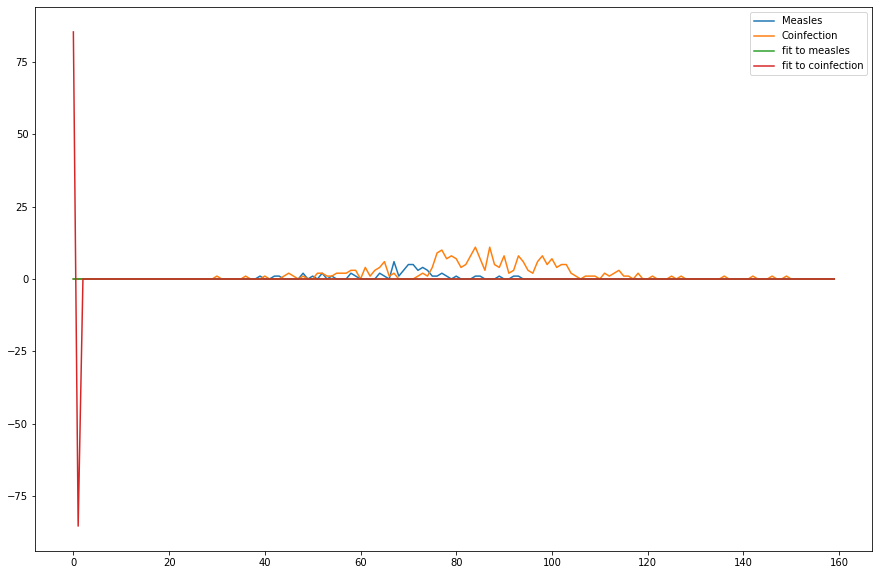

In [24]:

plt.figure(figsize=(15,10))
time_series=np.array((measles_timeseries,coinf_timeseries))
plt.plot(time_series[0],label="Measles")
plt.plot(time_series[1],label="Coinfection")
plt.plot(fit_samp[0],label="fit to measles")
plt.plot(fit_samp[1],label="fit to coinfection")

plt.legend()
plt.show()

In [34]:
fit_samp[1]

array([ 8.53708370e+001, -8.53708370e+001,  6.64024228e-321,
        6.76672309e-320,  6.64024228e-321,  6.64024228e-321,
        6.95644429e-321,  6.64024228e-321,  6.64024228e-321,
        6.95644429e-321,  6.64024228e-321,  6.64024228e-321,
        6.95644429e-321,  6.64024228e-321,  6.64024228e-321,
        6.95644429e-321,  6.64024228e-321,  6.64024228e-321,
        6.95644429e-321,  6.64024228e-321,  6.64024228e-321,
        6.95644429e-321,  6.64024228e-321,  6.64024228e-321,
        6.95644429e-321,  6.64024228e-321,  6.64024228e-321,
        6.95644429e-321,  6.64024228e-321,  6.64024228e-321,
        6.95644429e-321,  6.64024228e-321,  6.64024228e-321,
        6.95644429e-321,  6.64024228e-321,  6.64024228e-321,
        6.95644429e-321,  6.64024228e-321,  6.64024228e-321,
        6.95644429e-321,  6.64024228e-321,  6.64024228e-321,
        6.95644429e-321,  6.64024228e-321,  6.64024228e-321,
        6.95644429e-321,  6.64024228e-321,  6.64024228e-321,
        6.95644429e-321,